In [ ]:
!pip install pandas matplotlib numpy

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [8]:
np.random.seed(42)

asset0:
Annual return: 1.05%
Annual volatility: 2.98%

asset1:
Annual return: 0.51%
Annual volatility: 5.98%

asset2:
Annual return: 3.46%
Annual volatility: 9.00%

asset3:
Annual return: 6.74%
Annual volatility: 11.89%

asset4:
Annual return: -2.44%
Annual volatility: 15.18%

asset5:
Annual return: 6.73%
Annual volatility: 17.95%

asset6:
Annual return: 2.09%
Annual volatility: 21.20%

asset7:
Annual return: -0.85%
Annual volatility: 24.01%

asset8:
Annual return: 5.51%
Annual volatility: 26.58%

asset9:
Annual return: 12.10%
Annual volatility: 30.13%

Random Portfolio:
Annual return: 4.89%
Annual volatility: 10.65%


<Figure size 1500x800 with 0 Axes>

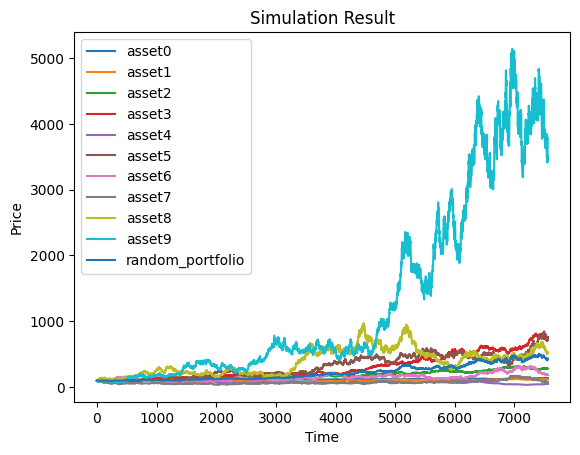

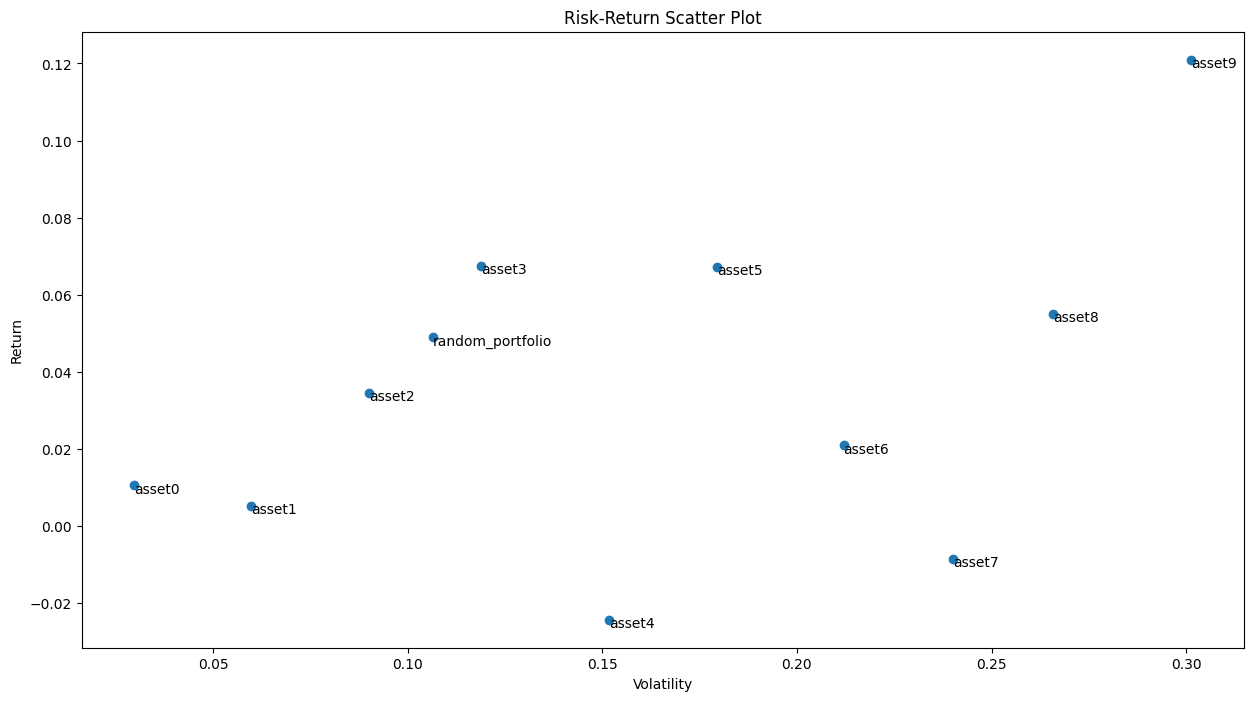

                    return  volatility
asset0            0.010475    0.029781
asset1            0.005133    0.059763
asset2            0.034554    0.089998
asset3            0.067388    0.118935
asset4           -0.024367    0.151794
asset5            0.067298    0.179485
asset6            0.020890    0.212004
asset7           -0.008532    0.240135
asset8            0.055100    0.265816
asset9            0.120971    0.301302
random_portfolio  0.048884    0.106546


In [11]:
class GeometricBrownianMotion:
    """Class for simulating Geometric Brownian Motion."""

    def __init__(self, mu: float, sigma: float, S0: float, dt: float, T: float):
        """
        Initialize the GeometricBrownianMotion object.

        Args:
            mu (float): Expected return.
            sigma (float): Volatility.
            S0 (float): Initial stock price.
            dt (float): Time increment.
            T (float): Final time.
        """
        self.mu = mu
        self.sigma = sigma
        self.S0 = S0
        self.dt = dt
        self.T = T

    def simulate(self) -> pd.DataFrame:
        """
        Simulate the Geometric Brownian Motion.

        Returns:
            pd.DataFrame: DataFrame containing the time and price paths.
        """
        N = int(self.T / self.dt)  # Number of time increments
        t = np.linspace(0, self.T, N + 1)  # Time vector
        W = np.cumsum(np.random.standard_normal(N + 1)) * np.sqrt(self.dt)  # Brownian increments
        S = self.S0 * np.exp((self.mu - 0.5 * self.sigma**2) * t + self.sigma * W)  # Geometric Brownian Motion
        return pd.DataFrame({"time": t, "price": S})


def generate_asset_params(num_assets: int, mu_base: float, sigma_base: float) -> list:
    """
    Generate asset parameters for multiple assets.

    Args:
        num_assets (int): Number of assets to generate.
        mu_base (float): Base value for expected return.
        sigma_base (float): Base value for volatility.

    Returns:
        list: List of dictionaries containing asset parameters.
    """
    return [
        {
            "name": f"asset{i}",
            "param": {
                "mu": mu_base * (i + 1),
                "sigma": sigma_base * (i + 1),
                "S0": 100,
                "dt": 1 / 252,
                "T": 30,
            },
        }
        for i in range(num_assets)
    ]


def simulate_assets(assets: list) -> pd.DataFrame:
    """
    Simulate multiple assets using Geometric Brownian Motion.

    Args:
        assets (list): List of dictionaries containing asset parameters.

    Returns:
        pd.DataFrame: DataFrame containing the price paths of multiple assets.
    """
    df = pd.DataFrame()
    for asset in assets:
        gbm = GeometricBrownianMotion(**asset["param"])
        df[asset["name"]] = gbm.simulate()["price"]
    return df


def calculate_risk_return(price: pd.Series) -> tuple:
    """
    Calculate the annual return and volatility of an asset.

    Args:
        price (pd.Series): Price series of the asset.

    Returns:
        tuple: Annual return and volatility as a tuple.
    """
    log_returns = np.log(price) - np.log(price.shift(1))
    log_returns.dropna(inplace=True)
    annual_return = log_returns.mean() * 252
    annual_volatility = log_returns.std() * np.sqrt(252)
    return annual_return, annual_volatility


def portfolio_price(weights, df, assets):
    return df[[asset["name"] for asset in assets]].mul(weights).sum(axis=1)


def portfolio_volatility(weights, df, dt, assets):
    price = portfolio_price(weights, df, assets)
    log_returns = np.log(price) - np.log(price.shift(1))
    log_returns.dropna(inplace=True)
    std = log_returns.std() * np.sqrt(1 / dt)
    return std


def portfolio_return(weights, df, dt, assets):
    price = portfolio_price(weights, df, assets)
    log_returns = np.log(price) - np.log(price.shift(1))
    log_returns.dropna(inplace=True)
    annual_return = log_returns.mean() / dt
    return annual_return


def calculate_summary(df, dt):
    log_returns = np.log(df) - np.log(df.shift(1))
    summary = pd.DataFrame(
        {
            "return": log_returns.mean() / dt,
            "volatility": log_returns.std() * np.sqrt(1 / dt),
        }
    )
    return summary


def main():
    """Main function to run the simulation."""
    mu_base = 0.01
    sigma_base = 0.03
    num_assets = 10
    dt = 1 / 252

    assets = generate_asset_params(num_assets, mu_base, sigma_base)
    df = simulate_assets(assets)

    # Calculate risk and return for each asset
    for asset in assets:
        price = df[asset["name"]]
        annual_return, annual_volatility = calculate_risk_return(price)
        print(f"{asset['name']}:")
        print("Annual return: {:.2f}%".format(annual_return * 100))
        print("Annual volatility: {:.2f}%".format(annual_volatility * 100))
        print()

    # Calculate risk and return for a random portfolio
    weights = np.random.random(len(assets))
    weights /= np.sum(weights)
    df["random_portfolio"] = portfolio_price(weights, df, assets)
    annual_return = portfolio_return(weights, df, dt, assets)
    annual_volatility = portfolio_volatility(weights, df, dt, assets)
    print("Random Portfolio:")
    print("Annual return: {:.2f}%".format(annual_return * 100))
    print("Annual volatility: {:.2f}%".format(annual_volatility * 100))

    # Plot the simulation result
    plt.figure(figsize=(15, 8))
    df.plot()
    plt.xlabel("Time")
    plt.ylabel("Price")
    plt.title("Simulation Result")
    plt.show()

    # Calculate summary and plot risk-return scatter plot
    summary = calculate_summary(df, dt)
    plt.figure(figsize=(15, 8))
    plt.scatter(summary["volatility"], summary["return"])
    for i in summary.index:
        plt.annotate(i, (summary["volatility"][i], summary["return"][i] - 0.002))
    plt.xlabel("Volatility")
    plt.ylabel("Return")
    plt.title("Risk-Return Scatter Plot")
    plt.show()

    print(summary)


if __name__ == "__main__":
    main()